In [1]:
# import required modules:
import matplotlib.pyplot as plt # to make plots
import numpy as np # for array manipulation and math functions
import scipy.signal as scs # for signal analysis
import glob # for finding files
import os as os
import warnings
# import fit models from the lmfit package
from lmfit.models import ExponentialModel, GaussianModel, PolynomialModel

# insert the path to your Data here:
datapath = "./Daten/"

# what data are we using?:
survey = 'sto2' # for SRT data: 'sto2'

# longitude we are looking at:
l_str = "25.0"

# order of the polynom to use to fit background:
deg_polynom = 7 # for HIsurvey data 0 is recommended, for SRT data 5 to 7

# max. number of gauss peaks to fit:
N_peaks = 12
add_gaussians = 6

# number of edge bins to ignore:
N_edge_bins = 250

# vLSR range in which we expect our signal:
signal_range = [-200,200]

In [2]:
pathlist = glob.glob(datapath+survey+"__GAL_"+l_str+"*_spec.*")

path = pathlist[0]

def read_HIsurvey_file(path, source = 'EBHIS'):
    """
    reads spectrum from the downloaded file for the source 'GASS', 'EBHIS', or 'LAB'
    
    default is 'GASS'
    
    returns:
    
    x: v_LSR
    y: T_A
    """

    file = open(path, 'r')
    i = 0
    
    os.remove(path[:-4]+'_EBHIS.txt')
    os.remove(path[:-4]+'_GASS.txt')
    os.remove(path[:-4]+'_LAB.txt')

    EBHIS = open(path[:-4]+'_EBHIS.txt','a+')
    GASS = open(path[:-4]+'_GASS.txt','a+')
    LAB = open(path[:-4]+'_LAB.txt','a+')

    dataset = None

    for line in file:
        i = i + 1
        if line[:3] == '%%E':
            dataset = 'EBHIS'
        elif line[:3] == '%%G':
            dataset = 'GASS'
        elif line[:3] == '%%L':
            dataset = 'LAB'
        elif line[0] == '%':
            print(line)
        else:
            if dataset == None:
                print(line)
            elif dataset == 'EBHIS':
                EBHIS.write(line)
            elif dataset == 'GASS':
                GASS.write(line)
            elif dataset == 'LAB':
                LAB.write(line)

    file.close()
    EBHIS.close()
    GASS.close()
    LAB.close()

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        dat = np.loadtxt(path[:-4]+'_'+source+'.txt')
    
    if dat.size == 0:
        for new_source in ('EBHIS','GASS','LAB'):
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                dat = np.loadtxt(path[:-4]+'_'+new_source+'.txt')
            if dat.size > 0:
                print('Dataset of '+source+' is empty. Source was switched to '+new_source)
                break
        
    x = dat[:,0]
    y = dat[:,1]
    
    return x, y

x, y = read_HIsurvey_file(path,source='EBHIS')

FileNotFoundError: [Errno 2] No such file or directory: './Daten/sto2__GAL_25.0_5.0_255_spec_EBHIS.txt'

[ 809.10192283  808.79275129  808.48357974 ... -301.75142403 -302.06059557
 -302.36976711]


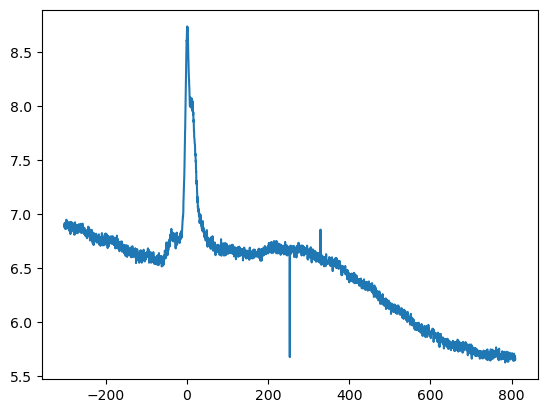

In [4]:
# load data:
pathlist = glob.glob(datapath+survey+"__GAL_"+l_str+"*_spec.*")


path = pathlist[0]

if survey == 'HIsurvey':
    x, y = read_HIsurvey_file(path)
elif survey == 'sto2':
    dat = np.loadtxt(path, delimiter=',', skiprows=1)
        
    # cut the edge bins, as they are unreliable
    dat_use = np.asarray(dat[N_edge_bins:-N_edge_bins])

    # x: v_LSR
    x = dat_use[:, 2]
    # y: T_A
    y = dat_use[:, 3]
else:
    raise ValueError('Unknown survey name. Please check whether the datapath and spelling are correct.')

print(x)

# plot the part of the spectrum we are actually using:
plt.plot(x,y)

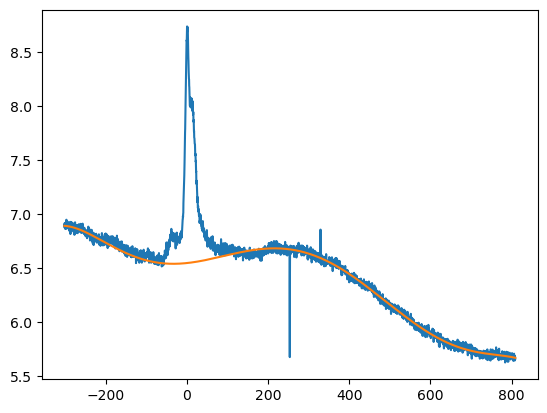

In [5]:
def coarseBackgroundModel(x,y,deg,signal_range):
    """
    coarse fit of a polynomial model to the entire data for a first background reduction:
    
    x: v_LSR
    y: T_A
    deg: degree of the polynom to fit to the data
    
    """
    # set up polynomial model
    poly_mod = PolynomialModel(deg, prefix='p1_')
    
    mask= ((x<signal_range[0]) | (x>signal_range[1]))
    #mask = ((x > signal_range[0]) & (x < signal_range[1]))
    x_ = x[mask]
    y_ = y[mask]
    
    # let lmfit guess the parameter values:
    p_bg = poly_mod.guess(y_, x=x_)
    
    # set up our background model (only polynomial here):
    mod_bg = poly_mod
    
    # initialize the model with the guessed parameters:
    init_bg = mod_bg.eval(p_bg, x=x_)
    
    # fit the model:
    out_bg = mod_bg.fit(y_, p_bg, x=x_)
    
    # return results:
    return p_bg, out_bg, mod_bg

# now do it:
p_bg, out_bg, mod_bg = coarseBackgroundModel(x,y,deg_polynom,signal_range)

background = mod_bg.eval(p_bg,x=x)

# and plot the result
plt.plot(x,y)
plt.plot(x,background)

[ 103.57246624   92.44229076   76.36537063   60.59762204   11.74851856
    0.61834308  -37.718928    -85.02217378  -88.73223227  -97.07986388
 -107.90086781 -115.01181326]


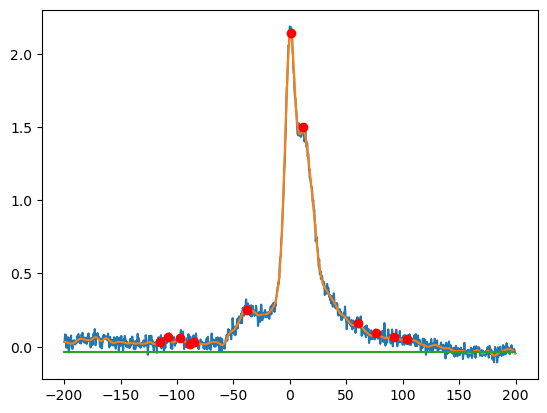

In [6]:
def getSignal(x,y,background,NPeaks = 6,signal_thr = None):
    """
    looks only at expected signal range and finds peaks within the range
    
    x: v_LSR
    y: T_A
    out_bg: fit results of the background model
    NPeaks: number of Gauss peaks to fit
    
    """
    
    # mask the expected signal range:
    s_mask = (x>signal_range[0])&(x<signal_range[1])
    
    # only look at the expected signal range for now:
    x_s = x[s_mask]
    signal_use = (y-background)[s_mask]
    
    if survey == 'sto2':
    
        b,a = scs.butter(3,0.07)
    
        zi = scs.lfilter_zi(b, a)
        z, _ = scs.lfilter(b, a, x_s, zi=zi*signal_use[0])
    
        z2, _ = scs.lfilter(b, a, z, zi=zi*z[0])
    
        signal_smooth = scs.filtfilt(b, a, signal_use)
    
    else:
        
        signal_smooth = signal_use # smoothing not necessary for HIsurvey
    
    #amp = (np.max(signal_use)-np.min(signal_use))
    #minimum = np.min(signal_use)
    
    amp = (np.max(signal_smooth)-np.min(signal_smooth))
    minimum = np.min(signal_smooth)
    
    s_min = signal_range[0]+50
    s_max = signal_range[1]-50
    
    s_mask_narrow = ((x_s>s_min)&(x_s<s_max))
    
    if signal_thr is None:
        # find peaks in the signal:
        peaks = scs.find_peaks(signal_smooth[s_mask_narrow], width=1)
    
        # sort them by prominence:
        prom = peaks[1]['prominences']
    else:
        # find peaks in the signal:
        peaks = scs.find_peaks(signal_smooth[s_mask_narrow], height = minimum + signal_thr*amp, width=1)
    
        # sort them by prominence:
        prom = peaks[1]['peak_heights']
    prom_save = prom.copy()
    prom.sort()
    
    # only use the most prominent peaks for our first guess of the Gauss peak centers:
    if NPeaks > len(prom): # if not enough peaks are found, reduce NPeaks!
        NPeaks = len(prom)
        print("reduced NPeaks to "+str(NPeaks))
    peaks_use = peaks[0][prom_save>=prom[-NPeaks]]
    
    peak_width = peaks[1]['widths'][prom_save>=prom[-NPeaks]]
    
    # save the peak positions for later
    gauss_centers = x_s[s_mask_narrow][peaks_use]
    
    peak_y = signal_use[s_mask_narrow][peaks_use]
    
    # alternatively you can set the gauss_centers by hand:
    ## gauss_centers = [-60,-30,0,20,50,100]
    
    # return the results:
    return x_s, signal_use, gauss_centers, peak_y, peak_width, signal_smooth

signal_thr = 0.01

# now do it
x_s, signal_use, gauss_centers, peak_y, peak_width, signal_smooth = getSignal(x,y,background,NPeaks=N_peaks, signal_thr=signal_thr)

amp = (np.max(signal_smooth)-np.min(signal_smooth))
minimum = np.min(signal_smooth)
threshold = minimum + signal_thr*amp


# and plot the found peaks on our data for a sanity check
plt.plot(x_s,signal_use,label='signal')
plt.plot(x_s,signal_smooth,label='smoothed signal')
plt.plot([np.min(x_s),np.max(x_s)],[threshold,threshold],label='signal_thr')
plt.scatter(gauss_centers,peak_y,color="red",zorder=10)

# you may have to adjust the number of peaks for the final fit
# to do so change N_peaks and run the entire notebook again

print(gauss_centers)

[[Model]]
    (Model(polynomial, prefix='p1_') + (((((((((((((((((Model(gaussian, prefix='g0_') + Model(gaussian, prefix='g1_')) + Model(gaussian, prefix='g2_')) + Model(gaussian, prefix='g3_')) + Model(gaussian, prefix='g4_')) + Model(gaussian, prefix='g5_')) + Model(gaussian, prefix='g6_')) + Model(gaussian, prefix='g7_')) + Model(gaussian, prefix='g8_')) + Model(gaussian, prefix='g9_')) + Model(gaussian, prefix='g10_')) + Model(gaussian, prefix='g11_')) + Model(gaussian, prefix='g12_')) + Model(gaussian, prefix='g13_')) + Model(gaussian, prefix='g14_')) + Model(gaussian, prefix='g15_')) + Model(gaussian, prefix='g16_')) + Model(gaussian, prefix='g17_')))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 599
    # data points      = 1293
    # variables        = 58
    chi-square         = 1.56337093
    reduced chi-square = 0.00126589
    Akaike info crit   = -8570.21371
    Bayesian info crit = -8270.65993
    R-squared          = 0.99244496
[[Variables]]

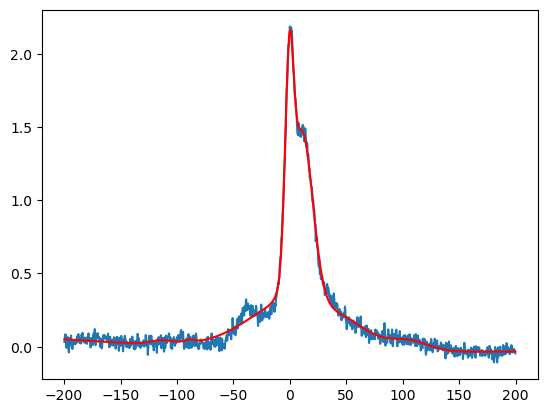

In [7]:
def detailedSignalFit(x_s, signal_use, gauss_centers, peak_width, poly_deg = 3):
    """
    detailed fit to signal (and remaining background)
    
    x_s: v_LSR data
    signal_use: T_A data
    gauss_centers: list of estimated center v_LSR of the Gauss peaks
    
    """
    
    center_variation = 5 # how much the fitted center is allowed to differ from the starting value
    
    sigma_min = 0
    sigma_max = 40
    
    amp_min = 0
    
    mask_edges = np.logical_or(x_s<signal_range[0]+50, x_s>signal_range[1]-50)
    
    ## now use a lesser degree polynom, that should suffice
    if not (poly_deg is None):
        poly1 = PolynomialModel(degree=poly_deg, prefix='p1_')
        p_s = poly1.guess(signal_use[mask_edges],x=x_s[mask_edges])
    
    # set up the first Gauss peak
    gaussX = GaussianModel(prefix='g'+str(0)+'_')
    
    # initialize the sum of all Gauss models with the first Gauss peak
    # add the rest later
    gaussians = gaussX
    
    # set up the list of parameters for the Gauss models with the first Gauss peak
    p_gauss = gaussX.make_params()
    
    if (poly_deg is None): p_s = p_gauss
    
    p_gauss['g'+str(0)+'_center'].set(value=gauss_centers[0], min=gauss_centers[0]-center_variation, max=gauss_centers[0]+center_variation) # center v_LSR
    p_gauss['g'+str(0)+'_sigma'].set(value=peak_width[0], min=sigma_min, max=sigma_max) # width of peak
    p_gauss['g'+str(0)+'_amplitude'].set(value=10, min=amp_min) # amplitude of peak
    
    ### (you can adjust these values if needed)
    
    # now set up the rest of the Gauss peaks:
    for i in np.arange(1,len(gauss_centers)):
        
        gaussX = GaussianModel(prefix='g'+str(i)+'_')
    
        gaussians = gaussians + gaussX
    
        p_gauss.update(gaussX.make_params())
    
        p_gauss['g'+str(i)+'_center'].set(value=gauss_centers[i], min=gauss_centers[i]-center_variation, max=gauss_centers[i]+center_variation)
        p_gauss['g'+str(i)+'_sigma'].set(value=peak_width[i], min=sigma_min, max=sigma_max)
        p_gauss['g'+str(i)+'_amplitude'].set(value=10, min=amp_min)
    
    # add some extra gauss peaks with free parameters to patch up anything left
    for i in np.arange(len(gauss_centers),len(gauss_centers)+add_gaussians):
        
        gaussX = GaussianModel(prefix='g'+str(i)+'_')
        
        gaussians = gaussians + gaussX
    
        p_gauss.update(gaussX.make_params())
        
        p_gauss['g'+str(i)+'_center'].set(min=np.min(x_s)+50, max=np.max(x_s)-50)
        p_gauss['g'+str(i)+'_sigma'].set(min=sigma_min, max=sigma_max)
        p_gauss['g'+str(i)+'_amplitude'].set(min=amp_min)
    
    # assemble the model:  polynomial background + Gauss peaks
    if not (poly_deg is None): mod_s = poly1 + gaussians
    else: mod_s = gaussians
    
    # include parameters for the Gauss peaks in the parameter list
    p_s.update(p_gauss)

    # initialize model with the parameters
    init_s = mod_s.eval(p_s, x=x_s)
    # fit model
    out_s = mod_s.fit(signal_use, p_s, x=x_s)
    
    # return results
    return p_s, out_s, mod_s, gaussians

# now do it
p_s, out_s, mod_s, mod_s_only = detailedSignalFit(x_s, signal_use, gauss_centers, peak_width)

# and plot the result
plt.plot(x_s, signal_use)
plt.plot(x_s, out_s.best_fit,color="red")
#plt.plot(x_s, out_s.eval_components(x=x_s)['p1_'])

print(out_s.fit_report(min_correl=0.5))

In [23]:
#background = out_s.eval_components(x=x_s)['p1_']
#x_s_, signal_use_, gauss_centers, peak_y, peak_width, signal_smooth_ = getSignal(x_s,signal_use-background,NPeaks=N_peaks)#N_peaks)

## and plot the found peaks on our data for a sanity check
#plt.plot(x_s_,signal_use_)
#plt.plot(x_s_,signal_smooth_)
#plt.scatter(gauss_centers,peak_y,color="red",zorder=10)

#plt.show()

#plt.figure()
## now do it
#p_s, out_s, mod_s, mod_s_only = detailedSignalFit(x_s, signal_use_, gauss_centers, peak_width, poly_deg=None)

## and plot the result
#plt.plot(x_s, signal_use_)
#plt.plot(x_s, out_s.best_fit,color="red")
#plt.plot(x_s, out_s.eval_components(x=x_s)['p1_'])

#print(out_s.fit_report(min_correl=0.5))

[[Model]]
    ((((((((((((((((((Model(gaussian, prefix='g0_') + Model(gaussian, prefix='g1_')) + Model(gaussian, prefix='g2_')) + Model(gaussian, prefix='g3_')) + Model(gaussian, prefix='g4_')) + Model(gaussian, prefix='g5_')) + Model(gaussian, prefix='g6_')) + Model(gaussian, prefix='g7_')) + Model(gaussian, prefix='g8_')) + Model(gaussian, prefix='g9_')) + Model(gaussian, prefix='g10_')) + Model(gaussian, prefix='g11_')) + Model(gaussian, prefix='g12_')) + Model(gaussian, prefix='g13_')) + Model(gaussian, prefix='g14_')) + Model(gaussian, prefix='g15_')) + Model(gaussian, prefix='g16_')) + Model(gaussian, prefix='g17_')) + Model(polynomial, prefix='p1_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1208
    # data points      = 3596
    # variables        = 62
    chi-square         = 4.12685538
    reduced chi-square = 0.00116776
    Akaike info crit   = -24221.1418
    Bayesian info crit = -23837.5120
    R-squared          = 0.99491663
[[Variables]

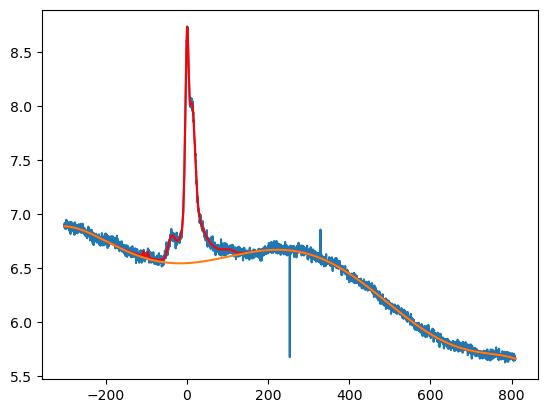

In [24]:
def fullDataFit(x,y,p_s,out_s,mod_s_only,p_bg,out_bg,mod_bg):
    """
    apply model to entire data:
    
    x: v_LSR
    y: T_A
    
    p_s: signal model parameters
    out_s: signal model fit results
    mod_s: signal model with background
    mod_s_only: signal model without background
    
    p_bg: background model parameters
    out_bg: background model fit results
    mod_bg: background model
    
    """
    # assemble model: Gauss peaks + polynomial background
    mod = mod_s_only + mod_bg

    # get all parameters (signal and background)
    pars = p_s
    pars.update(p_bg)

    # use previous best values as starting points for all parameters:
    
    for name in out_s.best_values:
        pars[name].set(value = out_s.best_values[name])
        
    for name in out_bg.best_values:
        pars[name].set(value = out_bg.best_values[name])

    # initialize the model with the parameters
    init = mod.eval(pars, x=x)

    # fit the model
    out = mod.fit(y, pars, x=x)
    
    # return results
    return out

# now do it
out = fullDataFit(x,y,p_s,out_s,mod_s_only,p_bg,out_bg,mod_bg)

# and plot the result
plt.plot(x,y)
plt.plot(x,out.best_fit,color="red")
plt.plot(x,out.eval_components(x=x)['p1_'])

print(out.fit_report(min_correl=0.5))

In [26]:
def fit(x,y,N_peaks,deg_polynom):
    """
    to iterate over many files it can be useful to write a single function that
    perform all the above steps
    
    x: v_LSR
    y: T_A
    N_peaks: number of Gauss peaks to fit
    deg_polynom: degree of the polynom to fit to the background
    """
    # first the background model estimation
    p_bg, out_bg, mod_bg = coarseBackgroundModel(x,y,deg_polynom,signal_range)
    
    background = mod_bg.eval(p_bg,x=x)
    
    # then get the signal
    x_s, signal_use, gauss_centers, peaks, peak_width, _ = getSignal(x,y,background,NPeaks=N_peaks,signal_thr=0.01)
    
    # fit Gauss peaks to signal
    p_s, out_s, mod_s, mod_s_only = detailedSignalFit(x_s, signal_use, gauss_centers, peak_width)
    
    # now apply this model to the entire data
    out = fullDataFit(x,y,p_s,out_s,mod_s_only,p_bg,out_bg,mod_bg)

    # retrieve the model components (polynom and the Gaussian peaks)
    comps = out.eval_components(x=x)
    
    # return results
    return out, comps, gauss_centers

In [27]:
# now let's perform all of the above for all measurements with the same longitude and
# compare the results

# allocate space for the v_LSR and T_A data for all files in the pathlist
# x: v_LSR
x = dict()
#x = np.zeros((len(pathlist),4096-2*N_edge_bins))
# y: T_A
y = dict()
#y = np.zeros((len(pathlist),4096-2*N_edge_bins))
print(np.shape(x),np.shape(y))
# y_fit: fitted T_A model
y_fit = y.copy()
# compslist: list of the components of each model fitted
compslist = [dict() for x in range(len(pathlist))]
# Ngaussians: number of fitted Gauss peaks
Ngaussians = np.zeros(len(pathlist))

# now iterate over the list of filenames
for i in np.arange(0,len(pathlist)):
    # grab a filename
    path = pathlist[i]
    print("File: "+path)
    
    if survey == 'HIsurvey':
        x[str(i)], y[str(i)] = read_HIsurvey_file(path)
    elif survey == 'sto2':
        dat = np.loadtxt(path, delimiter=',', skiprows=1)
        
        # cut the edge bins, as they are unreliable
        dat_use = np.asarray(dat[N_edge_bins:-N_edge_bins])

        # x: v_LSR
        x[str(i)] = dat_use[:, 2]
        # y: T_A
        y[str(i)] = dat_use[:, 3]
    else:
        raise ValueError('Unknown survey name. Please check whether the datapath and spelling are correct.')
    
    # now we use our single function that performs the entire fit process above at once
    out, comps, gauss_centers = fit(x[str(i)],y[str(i)],N_peaks,deg_polynom)
    
    # save the results:
    compslist[i] = comps
    Ngaussians[i] = len(gauss_centers)
    y_fit[str(i)] = out.best_fit
    
    # print a full report on the fit results:
    print(out.fit_report(min_correl=0.5))

() ()
File: ./Daten/sto2__GAL_25.0_5.0_255_spec.csv
[[Model]]
    ((((((((((((((((((Model(gaussian, prefix='g0_') + Model(gaussian, prefix='g1_')) + Model(gaussian, prefix='g2_')) + Model(gaussian, prefix='g3_')) + Model(gaussian, prefix='g4_')) + Model(gaussian, prefix='g5_')) + Model(gaussian, prefix='g6_')) + Model(gaussian, prefix='g7_')) + Model(gaussian, prefix='g8_')) + Model(gaussian, prefix='g9_')) + Model(gaussian, prefix='g10_')) + Model(gaussian, prefix='g11_')) + Model(gaussian, prefix='g12_')) + Model(gaussian, prefix='g13_')) + Model(gaussian, prefix='g14_')) + Model(gaussian, prefix='g15_')) + Model(gaussian, prefix='g16_')) + Model(gaussian, prefix='g17_')) + Model(polynomial, prefix='p1_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1208
    # data points      = 3596
    # variables        = 62
    chi-square         = 4.12685538
    reduced chi-square = 0.00116776
    Akaike info crit   = -24221.1418
    Bayesian info crit = -23837.5

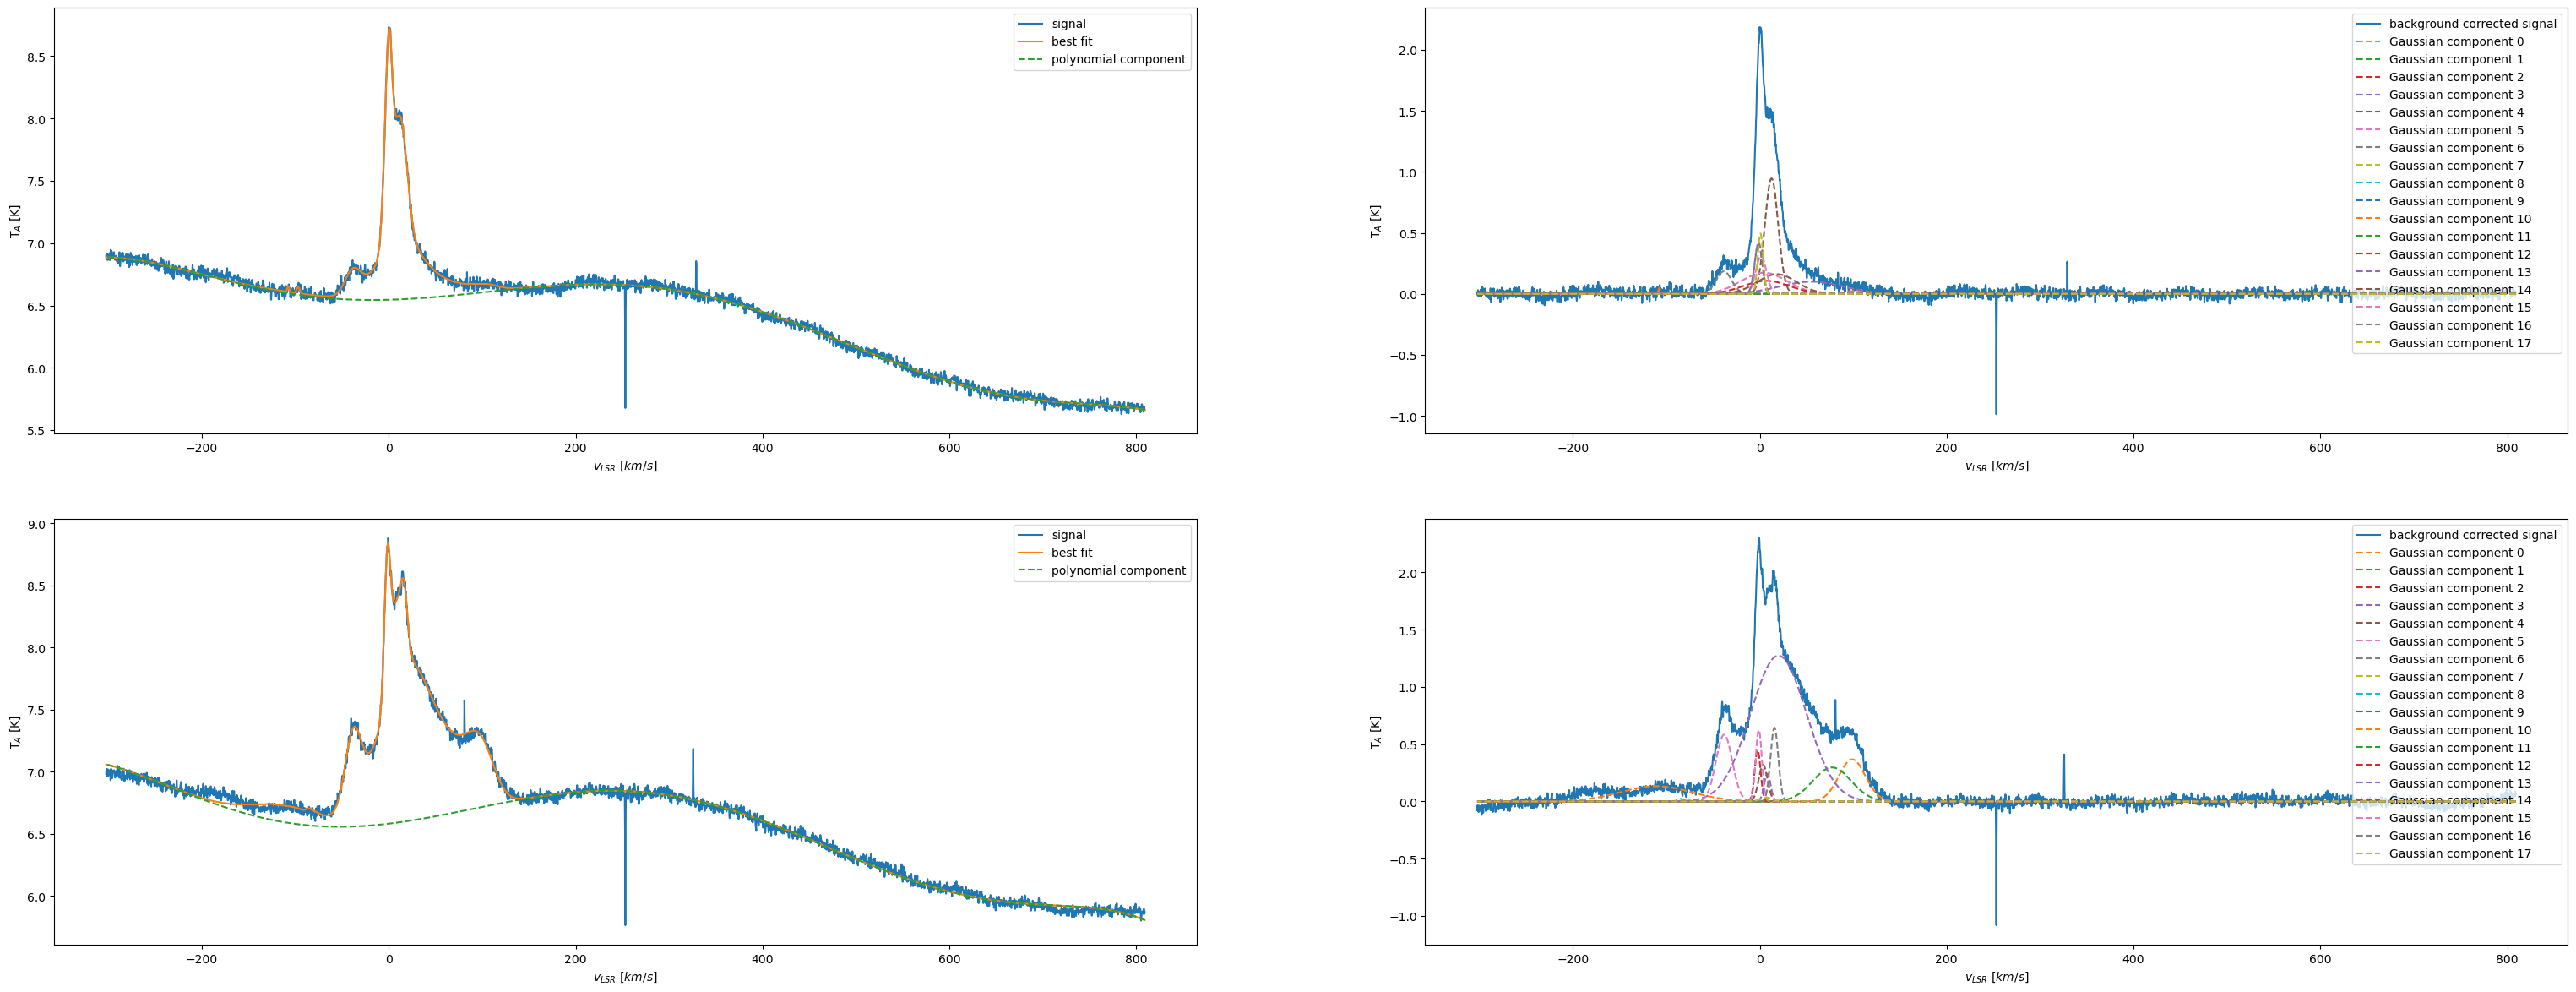

In [28]:
# let's plot the result

# first create a figure with the correct number of subplots
# we will be plotting the entire fit model on the left, and the decomposition on the right
fig, axes = plt.subplots(len(pathlist), 2, figsize=(3*12.8, 1.5*len(pathlist)*4.8))

if len(pathlist) == 1:
    # plot the data
    axes[0].plot(x[str(0)], y[str(0)], label="signal")
    # plot the fit results
    axes[0].plot(x[str(0)], y_fit[str(0)], '-', label='best fit')
    # plot the polynomial model
    axes[0].plot(x[str(0)], compslist[0]['p1_'], '--', label='polynomial component')
    
    # set the labels on the axes
    axes[0].set_xlabel('$v_{LSR}$ [$km/s$]')
    axes[0].set_ylabel('T$_{A}$ [K]')

    # plot the data
    axes[1].plot(x[str(0)], y[str(0)]-compslist[0]["p1_"], label="background corrected signal")
    # plot each of the Gauss peaks separately
    for j in np.arange(0,int(Ngaussians)):
        axes[1].plot(x[str(0)], compslist[0]['g'+str(j)+'_'], '--', label='Gaussian component '+str(j))
    # plot the polynom
    #axes[i,1].plot(x[i], compslist[i]['p1_'], '--', label='polynomial component')

    # add legends
    axes[0].legend(loc="upper right")
    axes[1].legend(loc="upper right")

    # add axis labels
    axes[1].set_xlabel('$v_{LSR}$ [$km/s$]')
    axes[1].set_ylabel('T$_{A}$ [K]')

else:
    # the iterate over all the files
    for i in np.arange(0,len(pathlist)):
    
        # plot the data
        axes[i,0].plot(x[str(i)], y[str(i)], label="signal")
        # plot the fit results
        axes[i,0].plot(x[str(i)], y_fit[str(i)], '-', label='best fit')
        # plot the polynomial model
        axes[i,0].plot(x[str(i)], compslist[i]['p1_'], '--', label='polynomial component')
    
        # set the labels on the axes
        axes[i,0].set_xlabel('$v_{LSR}$ [$km/s$]')
        axes[i,0].set_ylabel('T$_{A}$ [K]')

        # plot the data
        axes[i,1].plot(x[str(i)], y[str(i)]-compslist[i]["p1_"], label="background corrected signal")
        # plot each of the Gauss peaks separately
        for j in np.arange(0,int(Ngaussians[i]+add_gaussians)):
            axes[i,1].plot(x[str(i)], compslist[i]['g'+str(j)+'_'], '--', label='Gaussian component '+str(j),zorder=10)
        # plot the polynom
        #axes[i,1].plot(x[i], compslist[i]['p1_'], '--', label='polynomial component')

        # add legends
        axes[i,0].legend(loc="upper right")
        axes[i,1].legend(loc="upper right")

        # add axis labels
        axes[i,1].set_xlabel('$v_{LSR}$ [$km/s$]')
        axes[i,1].set_ylabel('T$_{A}$ [K]')

# save and show the plot
plt.savefig("Gauss_fit_baseline_l_"+l_str+".png")
plt.show()